# Stencil Computation for 2D Gray-Scott Using Julia

In [2]:
] add Metal

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [3]:
] add BenchmarkTools

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [4]:
] add ProgressMeter

   Resolving package versions...
   Installed ProgressMeter ─ v1.10.2
    Updating `~/.julia/environments/v1.9/Project.toml`
  [92933f4c] + ProgressMeter v1.10.2
    Updating `~/.julia/environments/v1.9/Manifest.toml`
  [92933f4c] + ProgressMeter v1.10.2
Precompiling project...
  ✓ ProgressMeter
  1 dependency successfully precompiled in 3 seconds. 436 already precompiled. 3 skipped during auto due to previous errors.


In [5]:
] add KernelAbstractions

   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
⌃ [63c18a36] + KernelAbstractions v0.9.18
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [6]:
] add Plots

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [7]:
] add ColorTypes

   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
⌅ [3da002f7] + ColorTypes v0.11.5
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [1]:
using Metal # for Metal GPU access

In [2]:
using BenchmarkTools # for benchmarking

In [3]:
using ProgressMeter # for progress monitoring

In [4]:
using Plots, ColorTypes # for plotting

# Gray-Scott Reaction-Diffusion Model

The Gray-Scott Reaction-Diffusion model is a mathematical model used to describe how two interacting substances, typically denoted as $U$ and $V$, evolve over time in a spatial domain. This model captures the combined effects of chemical reactions and diffusion, leading to complex pattern formations such as spots, stripes, and waves, which resemble natural phenomena like animal skin patterns or chemical reactions in a petri dish.

## Equations

The evolution of $ U $ and $ V $ over time is described by the following partial differential equations (PDEs):

$$
\frac{\partial U}{\partial t} = D_u \nabla^2 U - UV^2 + F(1 - U)
$$

$$
\frac{\partial V}{\partial t} = D_v \nabla^2 V + UV^2 - (F + k)V
$$

- **$D_u$**: Diffusion coefficient of $U$, controlling its spread rate.
- **$D_v$**: Diffusion coefficient of $V$, controlling its spread rate.
- **$F$**: Feed rate of  $U$, representing the replenishment of  $U$ in the system.
- **$ k $**: Kill rate of $V$, representing the removal of $V$ from the system.
- **$ \nabla^2 $**: Laplacian operator, representing the diffusion term.

# 2D 5-Point Stencil in the Gray-Scott Reaction-Diffusion Model

The 2D 5-point stencil is used to compute the diffusion terms ($ D_u \nabla^2 U $ and $ D_v \nabla^2 V $) in the Gray-Scott reaction-diffusion equations. It helps model how the substances $ U $ and $V $ spread through the 2D spatial domain by capturing the local flow of concentration between neighboring points.



## Mathematical Formulation

The Laplacian of a function $ u $ at point $(i, j)$ using the 2D 5-point stencil is approximated as:



$$
\nabla^2 u_{i, j} \approx \frac{1}{h^2} \left( u_{i-1, j} + u_{i+1, j} - 2 \cdot u_{i, j} \right) + \frac{1}{h^2} \left( u_{i, j-1} + u_{i, j+1} - 2 \cdot u_{i, j} \right)
$$

- **$ h $** is the grid spacing.
- The approximation relies on the difference between the central point and its neighbors, scaled by the grid spacing.

## CPU (Single-Threaded) Implementation of the Gray-Scott Equation

In [5]:
function laplacian(A, x, y, dx)
    @inbounds DAx = (A[x-1, y] - (2 * A[x, y]) + A[x+1, y]) / dx
    @inbounds DAy = (A[x, y-1] - (2 * A[x, y]) + A[x, y+1]) / dx
    return DAx + DAy
end

laplacian (generic function with 1 method)

In [6]:
function calculate_gs_cpu!(U, V, D_u, D_v, F, k, dt, dx, nx, ny, noise)
    # Allocate some temporary arrays for Laplacian results
    ΔU = zeros(nx, ny)
    ΔV = zeros(nx, ny)

    # Compute diffusion
    for x in 2:(nx-1), y in 2:(ny-1)
        @inbounds ΔU[x, y] = laplacian(U, x, y, dx)
        @inbounds ΔV[x, y] = laplacian(V, x, y, dx)
    end

    # Compute and update concentration fields
    UVV = U .* V .* V
    N = noise .* randn(nx, ny)
    U .+= (D_u .* ΔU .- UVV .+ F .* (1 .- U) .+ N) .* dt
    V .+= (D_v .* ΔV .+ UVV .- (F .+ k) .* V) .* dt

    return
end
function simulate_gs_cpu(n = 500 #=Grid size=#, nsteps = 10000 #=Number of iterations=# ;
                         init_multi = 0.5,   # Multiplier for initial disturbance
                         noise = 0.0,        # How much noise to add to U
                         D_u = 0.16,         # Diffusion rate of U
                         D_v = 0.08,         # Diffusion rate of V
                         F = 0.035,          # Feed rate
                         k = 0.06,           # Kill rate
                         dt = 1.0,           # Time step
                         dx = 1.0,           # Spatial step
                         plot_every = 500)   # Plot every 500 steps

    # Initialize concentration fields U and V
    U = rand(0.0:0.001:0.1, n, n)
    V = zeros(n, n)

    # Set up an initial small disturbance
    n_mid = div(n, 2)
    U[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 1.0 .* init_multi
    V[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.5 .* init_multi

    # Set up a progress bar
    prog = Progress(div(nsteps, plot_every))

    # Set up a figure for the heatmaps
    plt = Plots.plot(title="Gray-Scott Model", xlabel="X", ylabel="Y", size=(600, 600))

    # Simulation loop
    anim = Plots.@animate for T in 1:div(nsteps, plot_every)
        # Update the U and V concentrations
        for t in 1:plot_every
            calculate_gs_cpu!(U, V, D_u, D_v, F, k, dt, dx, n, n, noise)
        end

        # Update the progress bar
        next!(prog)

        # Plot the current U concentrations
        Plots.heatmap!(plt, U, color=cgrad([:black, :blue, :white]), clims=extrema(U), title="Gray-Scott Model")
    end
    gif(anim, "gs_cpu_serial.gif"; fps=10)
end

simulate_gs_cpu (generic function with 3 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


 47.544383 seconds (393.20 M allocations: 106.220 GiB, 6.18% gc time, 6.19% compilation time: 50% of which was recompilation)


[ Info: Saved animation to /Users/omairyrm/Library/CloudStorage/GoogleDrive-rabab.omairy@gmail.com/My Drive/Colab Notebooks/gs_cpu_serial.gif


Plots.AnimatedGif("/Users/omairyrm/Library/CloudStorage/GoogleDrive-rabab.omairy@gmail.com/My Drive/Colab Notebooks/gs_cpu_serial.gif")
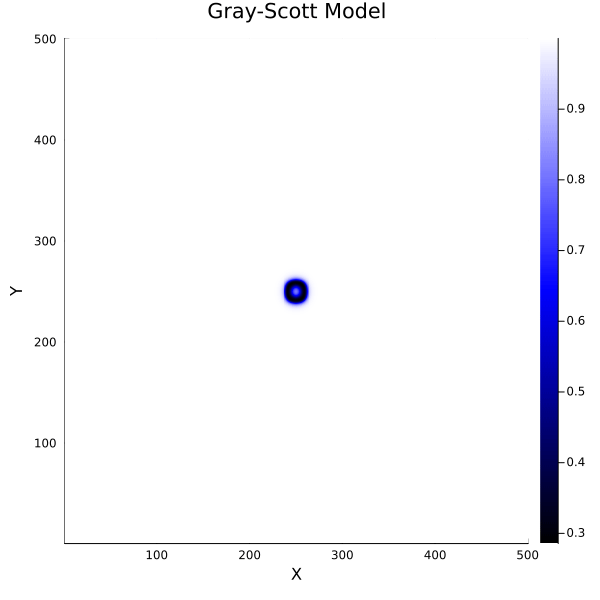

In [7]:
@time simulate_gs_cpu(500, 10000)

## CPU (Multi-Threaded) Implementation of the Gray-Scott Equation

In [8]:
function calculate_gs_cpu_mt!(U, V, D_u, D_v, F, k, dt, dx, nx, ny, noise)
    # Allocate U and V temporaries for updates
    DU = Matrix{Float32}(undef, nx, ny)
    DV = Matrix{Float32}(undef, nx, ny)

    # Compute diffusion and concentration fields changes
    Threads.@threads for y in 2:(ny-1)
        for x in 2:(nx-1)
            # Compute diffusion
            ΔU = laplacian(U, x, y, dx)
            ΔV = laplacian(V, x, y, dx)

            # Compute concentration fields changes
            UVV = @inbounds U[x, y] * (V[x, y] ^ 2)
            N = noise * randn()
            @inbounds DU[x, y] = D_u * ΔU - UVV + F * (1 - U[x, y]) + N
            @inbounds DV[x, y] = D_v * ΔV + UVV - (F + k) * V[x, y]
        end
    end

    # Update concentration fields
    Threads.@threads for y in 2:(ny-1)
        for x in 2:(nx-1)
            @inbounds U[x, y] += DU[x, y] * dt
            @inbounds V[x, y] += DV[x, y] * dt
        end
    end

    return
end
function simulate_gs_cpu_mt(n = 500 #=Grid size=#, nsteps = 10000 #=Number of iterations=# ;
                            init_multi = 0.5,   # Multiplier for initial disturbance
                            noise = 0.0,        # How much noise to add to U
                            D_u = 0.16,         # Diffusion rate of U
                            D_v = 0.08,         # Diffusion rate of V
                            F = 0.035,          # Feed rate
                            k = 0.06,           # Kill rate
                            dt = 1.0,           # Time step
                            dx = 1.0,           # Spatial step
                            plot_every = 500)   # Plot every 500 steps

    # Initialize concentration fields U and V
    U = rand(0.0:0.001:0.1, n, n)
    V = zeros(n, n)

    # Set up an initial small disturbance
    n_mid = div(n, 2)
    U[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 1.0 .* init_multi
    V[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.5 .* init_multi

    # Set up a progress bar
    prog = Progress(div(nsteps, plot_every))

    # Set up a figure for the heatmaps
    plt = Plots.plot(title="Gray-Scott Model", xlabel="X", ylabel="Y", size=(600, 600))

    # Simulation loop
    anim = Plots.@animate for T in 1:div(nsteps, plot_every)
        # Update the U and V concentrations
        for t in 1:plot_every
            calculate_gs_cpu_mt!(U, V, D_u, D_v, F, k, dt, dx, n, n, noise)
        end

        # Update the progress bar
        next!(prog)

        # Plot the current U concentrations
        Plots.heatmap!(plt, U, color=cgrad([:black, :blue, :white]), clims=extrema(U), title="Gray-Scott Model")
    end
    gif(anim, "gs_cpu_mt.gif"; fps=10)
end

simulate_gs_cpu_mt (generic function with 3 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


 33.561807 seconds (409.09 M allocations: 31.635 GiB, 4.86% gc time, 0.16% compilation time)


[ Info: Saved animation to /Users/omairyrm/Library/CloudStorage/GoogleDrive-rabab.omairy@gmail.com/My Drive/Colab Notebooks/gs_cpu_mt.gif


Plots.AnimatedGif("/Users/omairyrm/Library/CloudStorage/GoogleDrive-rabab.omairy@gmail.com/My Drive/Colab Notebooks/gs_cpu_mt.gif")
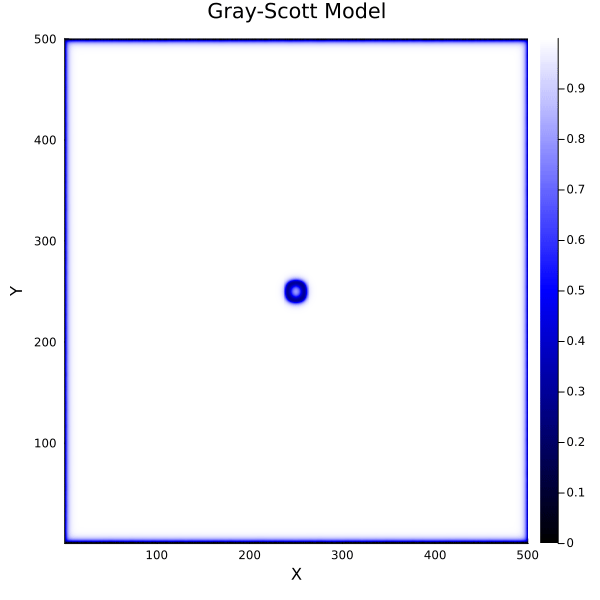

In [9]:
@time simulate_gs_cpu_mt(500, 10000)

## GPU (KernelAbstractions) Implementation of the Gray-Scott Equation

In [7]:
using KernelAbstractions

In [8]:
# add all options for different backends and array types
DEV = :Metal
T = Float32 

if DEV == :NVIDIA
    using CUDA
    ArrayKA = CUDA.CuArray
    Backend = CUDA.CUDABackend()
elseif DEV == :AMD
    using AMDGPU
    ArrayKA = AMDGPU.ROCArray
    Backend = AMDGPU.ROCBackend()
elseif DEV == :oneAPI
    using oneAPI
    ArrayKA = oneAPI.oneArray
    Backend = oneAPI.oneAPIBackend()
elseif DEV == :Metal
    using Metal
    ArrayKA = Metal.MtlArray
    Backend = Metal.MetalBackend()
else DEV == :CPU
    ArrayKA = Array
    Backend = CPU()
end

MetalBackend()

In [12]:
@kernel function calculate_gs_ka!(U, V, D_u::T, D_v::T, F::T, k::T, dt::T, dx::T, nx, ny, noise::T, rnd::T)
    x, y = @index(Global, NTuple)[1:2]

    # Skip ghost cells on the boundaries
    if (1 < x < nx) && (1 < y < ny)
        # Compute diffusion
        ΔU = laplacian(U, x, y, dx)
        ΔV = laplacian(V, x, y, dx)

        # Update concentration fields
        UVV = @inbounds U[x, y] * (V[x, y] ^ 2)
        N = noise * rnd
        DU = @inbounds D_u * ΔU - UVV + F * (1 - U[x, y]) + N
        DV = @inbounds D_v * ΔV + UVV - (F + k) * V[x, y]

        # Wait for all threads to read U and V
        @synchronize()

        # Update concentration fields
        @inbounds U[x, y] += DU * dt
        @inbounds V[x, y] += DV * dt

        # Wait for all threads to write U and V
       @synchronize()
    end

    # No return, KernelAbstractions doesn't allow these right now
end
function simulate_gs_ka(n = 500 #=Grid size=#, nsteps = 10000 #=Number of iterations=# ;
                        init_multi = 0.5,   # Multiplier for initial disturbance
                        noise = 0.0,        # How much noise to add to U
                        D_u = 0.16,         # Diffusion rate of U
                        D_v = 0.08,         # Diffusion rate of V
                        F = 0.035,          # Feed rate
                        k = 0.06,           # Kill rate
                        dt = 1.0,           # Time step
                        dx = 1.0,           # Spatial step
                        plot_every = 500)   # Plot every 500 steps

    # Initialize concentration fields U and V
    U = T.(rand(0.0:0.001:0.1, n, n))
    V = T.(zeros(n, n))

    # Set up an initial small disturbance
    n_mid = div(n, 2)
    U[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 1.0 * init_multi
    V[n_mid-5:n_mid+5, n_mid-5:n_mid+5] .= 0.5 * init_multi

    # Transfer to the GPU
    U_gpu = KernelAbstractions.allocate(Backend, T, n, n)
    V_gpu = KernelAbstractions.allocate(Backend, T, n, n)
    KernelAbstractions.copyto!(Backend, U_gpu, U)
    KernelAbstractions.copyto!(Backend, V_gpu, V)

    # Compile KA kernel
    kernel = calculate_gs_ka!(Backend, (cld(n, 16), cld(n, 16)))

    # Set up a progress bar
    prog = Progress(div(nsteps, plot_every))

    # Set up a figure for the heatmaps
    plt = Plots.plot(title="Gray-Scott Model", xlabel="X", ylabel="Y", size=(600, 600))

    # Simulation loop
    anim = Plots.@animate for t in 1:div(nsteps, plot_every)
        # Update the U and V concentrations
        for _ in 1:plot_every
            kernel(U_gpu, V_gpu, T(D_u), T(D_v), T(F), T(k), T(dt), T(dx), n, n, T(noise), T(randn()), ndrange=(n, n))
        end

        # Copy U results back to CPU array and synchronize
        KernelAbstractions.copyto!(Backend, U, U_gpu)
        KernelAbstractions.synchronize(Backend)

        # Update the progress bar
        next!(prog)

        # Plot the current U concentrations
        Plots.heatmap!(plt, U, color=cgrad([:black, :blue, :white]), clims=extrema(U), title="Gray-Scott Model")
    end
    gif(anim, "gs_ka.gif"; fps=10)
end

simulate_gs_ka (generic function with 3 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


 19.720280 seconds (394.66 M allocations: 12.623 GiB, 13.99% gc time)


[ Info: Saved animation to /Users/omairyrm/Library/CloudStorage/GoogleDrive-rabab.omairy@gmail.com/My Drive/Colab Notebooks/gs_ka.gif


Plots.AnimatedGif("/Users/omairyrm/Library/CloudStorage/GoogleDrive-rabab.omairy@gmail.com/My Drive/Colab Notebooks/gs_ka.gif")
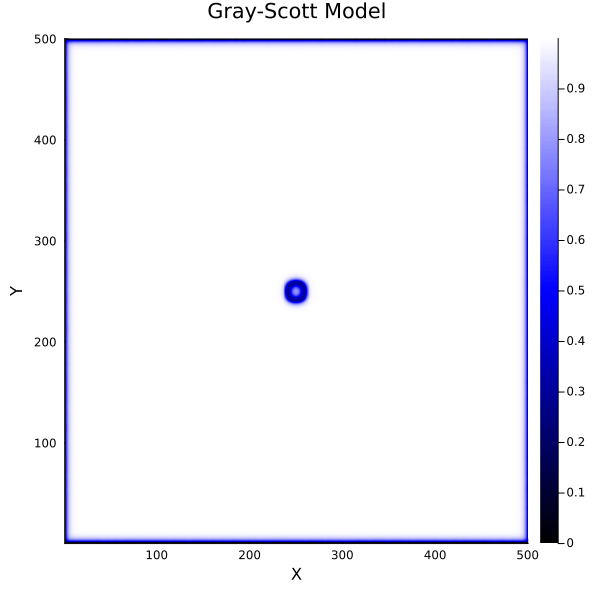

In [15]:
@time simulate_gs_ka(500, 10000)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


 43.586544 seconds (647.98 M allocations: 20.207 GiB, 16.32% gc time)


[ Info: Saved animation to /Users/omairyrm/Library/CloudStorage/GoogleDrive-rabab.omairy@gmail.com/My Drive/Colab Notebooks/gs_ka.gif


Plots.AnimatedGif("/Users/omairyrm/Library/CloudStorage/GoogleDrive-rabab.omairy@gmail.com/My Drive/Colab Notebooks/gs_ka.gif")
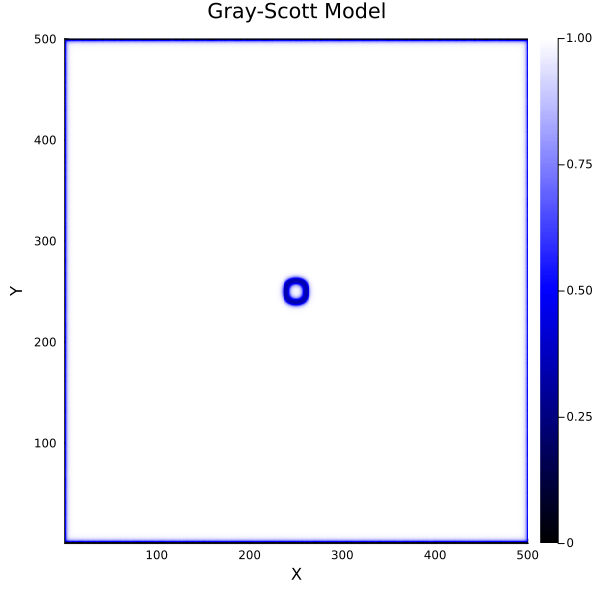

In [18]:
# Tweak some parameters
@time simulate_gs_ka(500, 50000; k=.06054, F=.07528, noise=0.0001, init_multi=1.0, plot_every=2000)